In [1]:
import ee
import folium
import geopandas as gpd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, losses, models, metrics, optimizers
from tensorflow.keras.callbacks import EarlyStopping

2023-08-18 16:08:02.416610: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-18 16:08:05.352125: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-08-18 16:08:05.352247: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [2]:
BANDS = ["b1", "CANNY"]
RESPONSE = "FAULTLINE"
FEATURES = BANDS + [RESPONSE]

KERNEL_SIZE = 64
COLUMNS = [
    tf.io.FixedLenFeature(shape=[KERNEL_SIZE, KERNEL_SIZE], dtype=tf.float32) for _ in FEATURES
]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

In [3]:
def parse_tfrecord(example_proto):
    """The parsing function.
    Read a serialized example into the structure defined by FEATURES_DICT.
    Args:
    example_proto: a serialized Example.
    Returns:
    A dictionary of tensors, keyed by feature name.
    """
    return tf.io.parse_single_example(example_proto, FEATURES_DICT)


def to_tuple(inputs):
    """Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
    Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
    Args:
    inputs: A dictionary of tensors, keyed by feature name.
    Returns:
    A tuple of (inputs, outputs).
    """
    inputsList = [inputs.get(key) for key in FEATURES]
    stacked = tf.stack(inputsList, axis=0)
    # Convert from CHW to HWC
    stacked = tf.transpose(stacked, [1, 2, 0])
    return stacked[:,:,:len(BANDS)], tf.squeeze(tf.cast(stacked[:,:,len(BANDS):], tf.int32))


def get_dataset(pattern):
    """Function to read, parse and format to tuple a set of input tfrecord files.
    Get all the files matching the pattern, parse and convert to tuple.
    Args:
    pattern: A file pattern to match in a Cloud Storage bucket.
    Returns:
    A tf.data.Dataset
    """
    glob = tf.io.gfile.glob(pattern)
    dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
    dataset = dataset.map(to_tuple, num_parallel_calls=5)
    return dataset

In [4]:
tf.random.set_seed(42)

#  1. Get Data

In [8]:
BATCH_SIZE = 16
BUFFER_SIZE = 2000

base_path = "gs://esg-satelite-data-warehouse/mars/modelling/themis_tempeterra_epsg3857_v1"

train_data_path = f"{base_path}/modelling_data_train.tfrecord.gz"
test_data_path = f"{base_path}/modelling_data_test.tfrecord.gz"
val_data_path = f"{base_path}/modelling_data_val.tfrecord.gz"

train_data_raw = get_dataset(train_data_path)
test_data_raw = get_dataset(test_data_path)
val_data_raw = get_dataset(val_data_path)


training_data = train_data_raw.shuffle(BUFFER_SIZE, reshuffle_each_iteration = False).batch(BATCH_SIZE)
test_data = test_data_raw.shuffle(BUFFER_SIZE, reshuffle_each_iteration = False).batch(BATCH_SIZE)
val_data = val_data_raw.shuffle(BUFFER_SIZE, reshuffle_each_iteration = False).batch(BATCH_SIZE)

# 2. Define model

In [11]:
def conv_block(input_tensor, num_filters):
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    return encoder

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    return decoder

def get_model():

    normalisation_layer = layers.Normalization()
    normalisation_layer.adapt(training_data.map(lambda x, _: x))

    inputs = layers.Input(shape=[None, None, len(BANDS)]) # 256
    normalised_inputs = normalisation_layer(inputs)
    encoder0_pool, encoder0 = encoder_block(normalised_inputs, 32) # 128
    encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64) # 64
    encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128) # 32
    encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256) # 16
    encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512) # 8
    center = conv_block(encoder4_pool, 1024) # center
    decoder4 = decoder_block(center, encoder4, 512) # 16
    decoder3 = decoder_block(decoder4, encoder3, 256) # 32
    decoder2 = decoder_block(decoder3, encoder2, 128) # 64
    decoder1 = decoder_block(decoder2, encoder1, 64) # 128
    decoder0 = decoder_block(decoder1, encoder0, 32) # 256
    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(decoder0)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    model.compile(
        optimizer=optimizers.SGD(learning_rate=1), 
        loss=losses.BinaryCrossentropy(),
        metrics=[
            metrics.BinaryIoU(target_class_ids=[1], name = "iou")
        ]
    )
    return model

# 3. Training

In [15]:
callbacks = []
es = EarlyStopping(
    monitor= "val_iou",
    patience=5,
    verbose=1,
    mode="max",
    restore_best_weights=True,
)
callbacks.append(es)

In [16]:
model = get_model()

EPOCHS = 20

history = model.fit(
    x=training_data,
    epochs=EPOCHS,
    validation_data=val_data,
    callbacks = callbacks
)

Epoch 1/20
63/63 [==============================] - 13s 102ms/step - loss: 0.4293 - iou: 0.2264 - val_loss: 0.5352 - val_iou: 0.0038
Epoch 2/20
63/63 [==============================] - 6s 86ms/step - loss: 0.3727 - iou: 0.3430 - val_loss: 0.5005 - val_iou: 0.0962
Epoch 3/20
63/63 [==============================] - 6s 87ms/step - loss: 0.3505 - iou: 0.3823 - val_loss: 0.4156 - val_iou: 0.2991
Epoch 4/20
63/63 [==============================] - 6s 87ms/step - loss: 0.3320 - iou: 0.4108 - val_loss: 0.4161 - val_iou: 0.3200
Epoch 5/20
63/63 [==============================] - 6s 87ms/step - loss: 0.3179 - iou: 0.4289 - val_loss: 0.3730 - val_iou: 0.4440
Epoch 6/20
63/63 [==============================] - 6s 86ms/step - loss: 0.3036 - iou: 0.4501 - val_loss: 0.3596 - val_iou: 0.5013
Epoch 7/20
63/63 [==============================] - 6s 85ms/step - loss: 0.2888 - iou: 0.4716 - val_loss: 0.3687 - val_iou: 0.5007
Epoch 8/20
63/63 [==============================] - 6s 87ms/step - loss: 0.2784 -

In [ ]:
#model.summary()

# 4. Results

In [17]:
def plot_results(x_train, y_train, x_pred_prob, x_pred_binary, title):
    fig, axs = plt.subplots(2,2)
    
    axs[0, 0].imshow(x_train)
    _ = axs[0, 0].axis('off')
    _ = axs[0, 0].set_title('Real Image') 
    
    axs[0, 1].imshow(y_train)
    _ = axs[0, 1].axis('off')
    _ = axs[0, 1].set_title('Real Faults')
    
    axs[1, 0].imshow(x_pred_prob)
    _ = axs[1, 0].axis('off')
    _ = axs[1, 0].set_title('Predicted Fault (prob)')
    
    axs[1, 1].imshow(x_pred_binary)
    _ = axs[1, 1].axis('off')
    _ = axs[1, 1].set_title('Predicted Fault (bin)')
    
    plt.suptitle(title)

In [46]:
def get_model_results(model, data, n_images = 1):
    # NOTE: Make sure "reshuffle_each_iteration = False" in data.shuffle(...)
    for i in range(n_images):
        # Get data
        x_train = np.expand_dims(np.concatenate([x for x, _ in data], axis=0)[i], axis=0)
        y_train = np.expand_dims(np.concatenate([y for _, y in data], axis=0)[i], axis=0)
        # Get predictions
        x_pred_prob = model.predict(x_train)
        x_pred_binary = (x_pred_prob > 0.5)*1
        # Get IOU metric
        iou_metric = metrics.BinaryIoU(target_class_ids=[1], name = "iou")
        iou_metric.update_state(y_true=y_train, y_pred=x_pred_prob)
        iou_value = iou_metric.result().numpy()
        
        plot_results(x_train[:,:,:,:1].squeeze(), y_train[0], x_pred_prob[0], x_pred_binary[0], title = f"IOU: {iou_value}") 

1/1 [==============================] - 0s 29ms/step


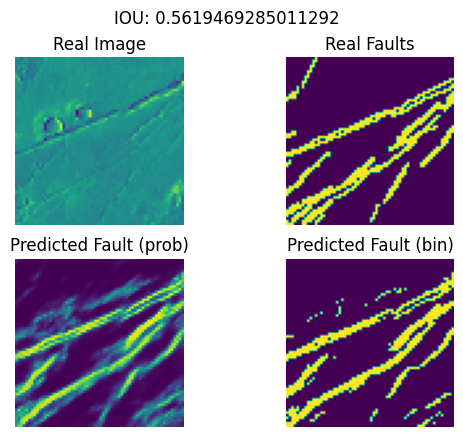

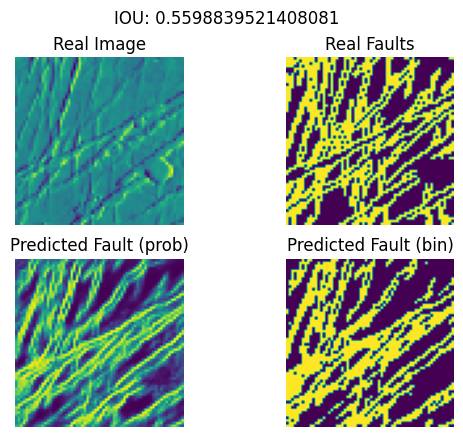

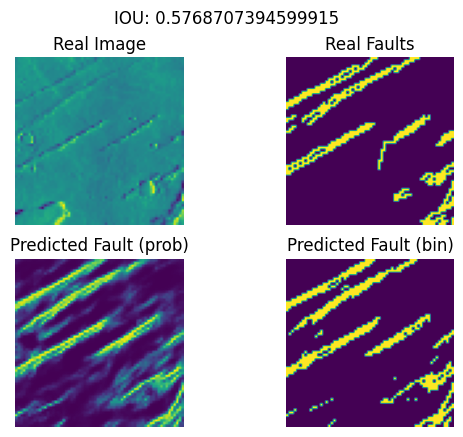

In [49]:
get_model_results(model, test_data, 3)

1/1 [==============================] - 0s 29ms/step


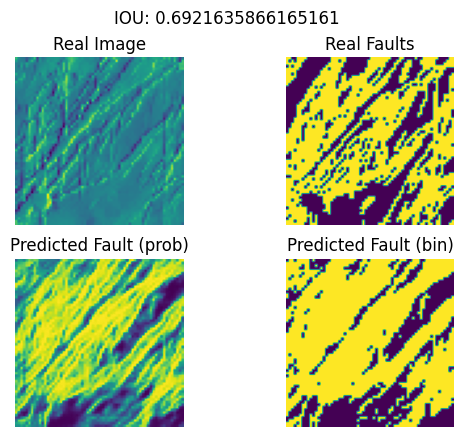

In [202]:
get_model_results(model, val_data, 1)

# 5. Apply Random Classifier

In [77]:
def random_classifier(training):
    y_train = np.concatenate([y for _, y in training], axis=0)
    output_shape = list(y_train.shape)

    y_random = np.random.randint(0, 2, output_shape)

    iou_metric = metrics.IoU(num_classes=2, target_class_ids=[1])
    iou_metric.update_state(y_true=y_train, y_pred=y_random)
    iou_value = iou_metric.result().numpy()
    return iou_value

In [78]:
random_classifier(training)

0.006375674